In [1]:
from pyntcloud import PyntCloud
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datagenerator import DataGenerator
import random
import itertools

/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if os.path.exists("datasetpath.txt"):
    dataset_path = open("datasetpath.txt", "r").read().replace("\n", "")
else:
    dataset_path = "../data"

data_generator = DataGenerator(dataset_path=dataset_path, input_type="voxelgrid", output_targets=["height", "weight"])

WARNING! Multiple manual measurements for QR-code: SAM-GOV-049 ../data/db/persons/c79b708e301d9c71_shaikh_1531300004131_40Aq4RZQ3gUZts74/measures/c79b708e301d9c71_measure_1531300841811_Lhp0PzvwnmlyRspG/c79b708e301d9c71_measure_1531300841811_Lhp0PzvwnmlyRspG.json
WARNING! Multiple manual measurements for QR-code: SAM-SNG-014 ../data/db/persons/f2467a1fb0c542b9_kamble_1530687006027_AVA2AqQDcVsHYrrK/measures/f2467a1fb0c542b9_measure_1531291525951_BhMYXh4Zeu9Jk7Zr/f2467a1fb0c542b9_measure_1531291525951_BhMYXh4Zeu9Jk7Zr.json
WARNING! Multiple manual measurements for QR-code: SAM-SNG-096 ../data/db/persons/f2467a1fb0c542b9_kamble_1530687464869_e6puVVsetdSpP7sH/measures/f2467a1fb0c542b9_measure_1531291761123_0ZS7kMnJLy70pe4I/f2467a1fb0c542b9_measure_1531291761123_0ZS7kMnJLy70pe4I.json


Number of samples: 50
50


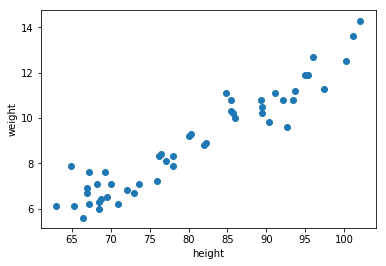

In [3]:
print("Number of samples:", len(data_generator.qrcodes_dictionary.keys()))
print(len(set(data_generator.qrcodes_dictionary.keys())))

targets = [target for key, (target, _, _) in data_generator.qrcodes_dictionary.items()]
targets = np.array(targets)

plt.scatter(targets[:,0], targets[:,1])
plt.xlabel("height")

plt.ylabel("weight")
plt.show()

Loading voxelgrid...
Resizing voxelgrid...
Rendering voxelgrid...


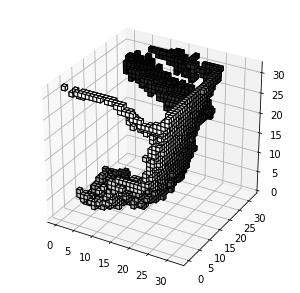

Done.


In [17]:
scatter_x = []
scatter_y = []

def load_voxelgrid(pcd_path, voxel_size_meters):

    # Load the voxelgrid.
    point_cloud = PyntCloud.from_file(pcd_path)
    voxelgrid_id = point_cloud.add_structure("voxelgrid", size_x=voxel_size_meters, size_y=voxel_size_meters, size_z=voxel_size_meters)
    voxelgrid = point_cloud.structures[voxelgrid_id].get_feature_vector(mode="density")

    return voxelgrid
    
    
def pad_voxelgrid(voxelgrid, target_shape):
    
    # Padding.
    pad_before = [0.0] * 3
    pad_after = [0.0] * 3
    for i in range(3):
        pad_before[i] = (target_shape[i] - voxelgrid.shape[i]) // 2 
        pad_before[i] = max(0, pad_before[i])
        pad_after[i] = target_shape[i] - pad_before[i] - voxelgrid.shape[i]
        pad_after[i] = max(0, pad_after[i])
    voxelgrid = np.pad(
        voxelgrid, 
        [(pad_before[0], pad_after[0]), (pad_before[1], pad_after[1]), (pad_before[2], pad_after[2])],
        'constant', constant_values=[(0, 0), (0, 0), (0, 0)]
    )
    
    return voxelgrid


def crop_voxelgrid(voxelgrid, target_shape):
    
    while voxelgrid.shape[0] > target_shape[0]:
        voxels_start = np.count_nonzero(voxelgrid[0,:,:] != 0.0)
        voxels_end = np.count_nonzero(voxelgrid[-1,:,:] != 0.0)
        if voxels_start > voxels_end:
            voxelgrid = voxelgrid[:-1,:,:]
        else:
            voxelgrid = voxelgrid[1:,:,:]
        
    while voxelgrid.shape[1] > target_shape[1]:
        voxels_start = np.count_nonzero(voxelgrid[:,0,:] != 0.0)
        voxels_end = np.count_nonzero(voxelgrid[:,-1,:] != 0.0)
        if voxels_start > voxels_end:
            voxelgrid = voxelgrid[:,:-1,:]
        else:
            voxelgrid = voxelgrid[:,1:,:]
        
    while voxelgrid.shape[2] > target_shape[2]:
        voxels_start = np.count_nonzero(voxelgrid[:,:,0] != 0.0)
        voxels_end = np.count_nonzero(voxelgrid[:,:,-1] != 0.0)
        if voxels_start > voxels_end:
            voxelgrid = voxelgrid[:,:,:-1]
        else:
            voxelgrid = voxelgrid[:,:,1:]
        
    return voxelgrid
   
    
def center_crop_voxelgrid(voxelgrid, target_shape):
    
    # Center crop.
    crop_start = [0.0] * 3
    crop_end = [0.0] * 3
    for i in range(3):
        crop_start[i] = (voxelgrid.shape[i] - target_shape[i]) // 2
        crop_start[i] = max(0, crop_start[i])
        crop_end[i] = target_shape[i] + crop_start[i]
    voxelgrid = voxelgrid[crop_start[0]:crop_end[0], crop_start[1]:crop_end[1], crop_start[2]:crop_end[2]]
    
    return voxelgrid
 
    
def render_voxelgrid(voxelgrid):
    figsize = (5, 5)
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection='3d')
    transformed_voxelgrid = np.flip(np.flip(voxelgrid, axis=2), axis=0)

    facecolors = np.zeros(transformed_voxelgrid.shape + (3,))
    for x, y, z in itertools.product(range(transformed_voxelgrid.shape[0]), range(transformed_voxelgrid.shape[1]), range(transformed_voxelgrid.shape[2])):
        color = (1.0 - y / 32)
        facecolors[x, y, z, 0] = color
        facecolors[x, y, z, 1] = color
        facecolors[x, y, z, 2] = color

    ax.voxels(transformed_voxelgrid, facecolors=facecolors, edgecolor="k")
    plt.show()
    plt.close()

    
voxel_size_meters = 0.01
target_shape = (32, 32, 32)

print("Loading voxelgrid...")
pcd_path = random.choice(data_generator.pcd_paths)
voxelgrid = load_voxelgrid(pcd_path, voxel_size_meters)
#render_voxelgrid(voxelgrid)

print("Resizing voxelgrid...")
voxelgrid = pad_voxelgrid(voxelgrid, target_shape)
voxelgrid = crop_voxelgrid(voxelgrid, target_shape)
assert voxelgrid.shape == target_shape, str(voxelgrid.shape)

print("Rendering voxelgrid...")
render_voxelgrid(voxelgrid)
print("Done.")

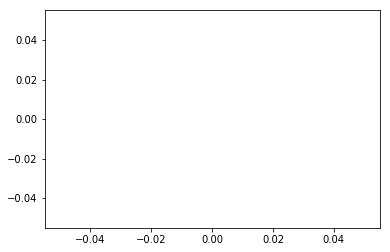

In [5]:
for voxel_size_meters in []:#[0.01, 0.1, 1.0]:
    num_samples = 10
    #voxels_before = np.zeros(num_samples)
    #voxels_after = np.zeros(num_samples)
    for i in range(num_samples):
        try:
            pcd_path = random.choice(data_generator.pcd_paths)
            voxelgrid = load_voxelgrid(pcd_path, voxel_size_meters)
            #voxels_before[i] = np.count_nonzero(voxelgrid != 0.0)
            voxelgrid = pad_voxelgrid(voxelgrid, target_shape)
            #voxels_after[i] = np.count_nonzero(voxelgrid != 0.0)
            voxelgrid = crop_voxelgrid(voxelgrid, target_shape)

        #render_voxelgrid(voxelgrid
        except Exception as e:
            print(e)

    error = np.abs(voxels_before - voxels_after)
    print(voxel_size_meters, np.mean(error))

plt.scatter(scatter_x, scatter_y)